### Task 1 - VTB bond USD - RUB
First find how much should be spent on fixed-income part and what is the discount. Interest rate is taken from yield curve for 6 months.

I assume that annual coupon of 0.01% is received by investing in 6-month bonds and rolling over. That is, we invest in bond with maturity of 6 months, and after it expires, we reinvest capital and coupon into another such bond. In practice, the coupon is so small that there is no real difference whether to calculate semiannual coupon as I do or to divide annual coupon by 2.

In [1]:
from math import sqrt, log, exp
rate =  4.15 / 100 #taken from https://www.moex.com/ru/marketdata/indices/state/g-curve/ for 6 months
face_value = 1 #100%
tenor = 0.5 #years
coupon = sqrt(1.0001) - 1 
capital_for_bond = (face_value + coupon) / (1 + rate)**tenor
discount = 1 - capital_for_bond
print('{}% of capital is to be paid for bond'.format(round(capital_for_bond*100, 2)))
print('Discount is ' + str(round(discount*100, 2)) + '%')

97.99% of capital is to be paid for bond
Discount is 2.01%


In [2]:
coupon

4.9998750062396624e-05

Now, to calculate option price, first we need to find volatility. I calculate volatility With AR(1)-GARCH(1,1) model, based on data for 1 year.

In [151]:
import yfinance as yf

pair = yf.Ticker("RUB=X")
pair_data = pair.history(period="1y")[['Close']]
pair_data.tail(3)

,Close
Date,
2020-10-07,78.3728
2020-10-08,78.0825
2020-10-09,77.1711


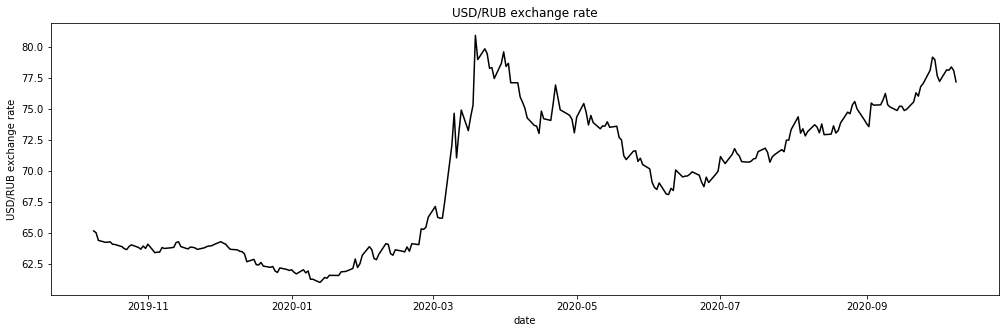

In [152]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize = (17, 5))
plt.plot(pair_data, color = 'black')
plt.xlabel('date')
plt.ylabel('USD/RUB exchange rate')
plt.title('USD/RUB exchange rate');

In [153]:
from arch import arch_model 
from arch.univariate import ARX, GARCH, StudentsT

pair_data_ret = pair_data.pct_change().dropna()
order =  10 / pair_data_ret.std()
mod = arch_model(order * pair_data_ret, mean = "ARX", lags = 1, vol='Garch', p=1, q=1, dist='skewstudent')
mod_fit = mod.fit(options = {'maxiter':500}, disp='off', show_warning = True)

In [154]:
sigma = (mod_fit.conditional_volatility[-1:][0] / order) * sqrt(252)
sigma = sigma[0]
print('Annualized volatility is ' + str(round(sigma * 100, 2)) + '%')

Annualized volatility is 14.14%


Next, find price for digital cash-or-nothing put option. Foreign risk-free rate was taken from Treasury yield curve.

In [155]:
S = 1
K = 0.95
T = 0.5
r = rate
q = 0.12 / 100  # foreign risk free rate, https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/textview.aspx?data=yield

In [156]:
from scipy.stats import norm
d1 = (log(S/K) + (r - q + sigma**2/2)*T) / (sigma*sqrt(T))
d2 = d1 - sigma*sqrt(T)
option_price = exp(-r*T)*norm.cdf(-d2) #выплата 100% от капитала
print('Option price is {}%'.format(round(option_price*100, 2)))

Option price is 24.8%


In [157]:
additional_income = 0.05 - coupon
print('We need to buy {}% of option'.format(round(additional_income*100, 4)))

We need to buy 4.995% of option


In [158]:
options_to_buy = additional_income * option_price 
print('Option price is {}%'.format(round(options_to_buy*100, 2)))
print('Option price is {}% of bond face value'.format(round(100*(options_to_buy/capital_for_bond), 2)))

Option price is 1.24%
Option price is 1.26% of bond face value


In [159]:
print('Instrument price is {}%'.format(round(100*(capital_for_bond + options_to_buy), 2)))

Instrument price is 99.23%


### Task 2 - 3Y Reverse Convertible

Calculate bond price. I include a small coupon since it has been said that by law, bond cannot pay no coupon.

In [53]:
r = 4.89/100 #taken from https://www.moex.com/ru/marketdata/indices/state/g-curve/ for 3 years
coupon = 0.0001
FV = 1
tenor = 3  
bond_price = (FV + coupon) / (1 + r)**3
print('Bond price is {}%'.format(round(bond_price, 2)*100))

Bond price is 87.0%


Calculate option price:

In [56]:
S = 1
K = 0.7
T = 3
sigma = 0.3

In [57]:
d1 = (log(S/K) + (r+sigma**2/2)*T) / (sigma*sqrt(T))
d2 = d1 - sigma * sqrt(T)
PV = K * exp(-r*T)
put_price = norm.cdf(-d2) * PV - norm.cdf(-d1) * S
print('Put price is {}%'.format(round(put_price*100, 2)))

Put price is 3.5%


In [58]:
annual_return  = (1 + put_price) ** (1/3) - 1
print('Annual return on option is {}%'.format(round(annual_return * 100,2)))

Annual return on option is 1.15%


In [59]:
print('Annual return on instrument is {}%'.format(round(100*((1 + coupon + put_price)**(1/3) - 1), 2)))
print('Total return on instrument is {}%'.format(round(100*(coupon + put_price),2)))

Annual return on instrument is 1.16%
Total return on instrument is 3.51%


In [61]:
print('Price of the instrument is {}%'.format(round(100*(bond_price - put_price),2)))

Price of the instrument is 83.17%


But this is not final price, as we also should account for the cost of buying the underlying if put option is exercised and costs associated with short-selling (i.e. commissions), among other.

### Task 3 - 3Y Barrier Reverse Convertible

Here I take pricing formulae for barrier options from Hull J., Options, futures and other derivatives. It is assumed that the price of underlying is monitored continiuosly. We have down-and-in put option with barrier less than strike. I assume dividend yield = 0 since I do not know what the underlying is.

In [62]:
S = 1
K = 1
H = 0.7
T = 3
sigma = 0.3
r = 4.89 / 100

In [63]:
lambda_ = (r + sigma**2 / 2)/sigma**2 
x1 = log(S/H)/(sigma*sqrt(T)) + lambda_*sigma*sqrt(T)
y = log(H**2/(S*K)) / (sigma*sqrt(T)) + lambda_*sigma*sqrt(T)
y1 = log(H/S) / (sigma*sqrt(T)) + lambda_*sigma*sqrt(T)

In [64]:
price_di = -S * norm.cdf(-x1) + K*exp(-r*T)*norm.cdf(-x1+sigma*sqrt(T)) + S*(H/S)**(2*lambda_)*(norm.cdf(y) - norm.cdf(y1)) - K*exp(-r*T)*(H/S)**(2*lambda_-2)*(norm.cdf(y-sigma*sqrt(T)) - norm.cdf(y1 - sigma*sqrt(T)))
print('Down-and-in put price is {}%'.format(round(price_di*100, 2)))

Down-and-in put price is 12.12%


In [65]:
annual_return_di  = (1 + price_di) ** (1/3) - 1
print('Annual return on option is {}%'.format(round(annual_return_di* 100, 4)))

Annual return on option is 3.8868%


In [69]:
print('Annual return on instrument is {}%'.format(round(100*((1 + coupon + price_di)**(1/3) - 1), 2)))
print('Total return on instrument is {}%'.format(round(100*(coupon + price_di),2)))

Annual return on instrument is 3.89%
Total return on instrument is 12.13%


In [71]:
print('Price of the instrument is {}%'.format(round(bond_price - price_di,2)*100))

Price of the instrument is 75.0%


Again, this price is not final for the reasons outlined above.